In [23]:
!pip install numpy pandas seaborn scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [24]:
import warnings

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error
import datetime

In [25]:
data_path = './daily_water_consumption.csv'
df = pd.read_csv(data_path, encoding='ascii', delimiter=',')

In [26]:
# constants / things
water_palette = ["#00BFFF", "#1E90FF", "#4682B4", "#5F9EA0", "#87CEEB"]
%matplotlib inline

# Plots / visualizations


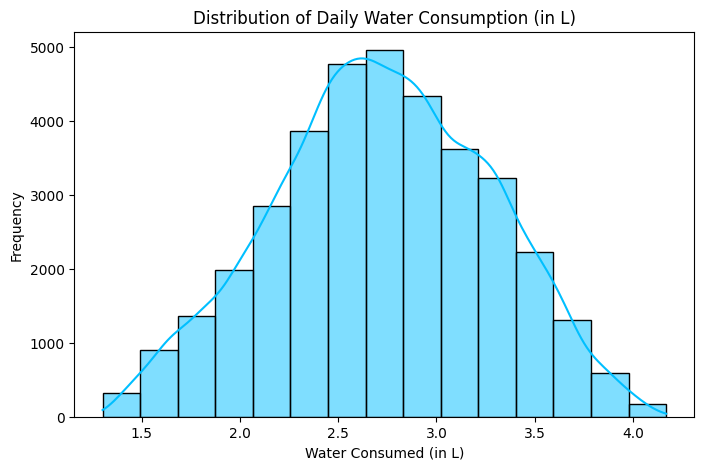

In [27]:
plt.figure(figsize=(8,5))
sns.histplot(df['Water_Consumed_Liters'], bins=15, kde=True, color='#00BFFF')
plt.title('Distribution of Daily Water Consumption (in L)')
plt.xlabel('Water Consumed (in L)')
plt.ylabel('Frequency')
plt.show()

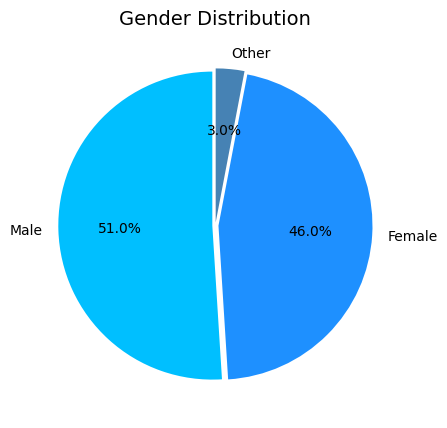

In [28]:
plt.figure(figsize=(5,5))
gender_counts = df['Gender'].value_counts()
explode = [0.02] * len(gender_counts)
df['Gender'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=[water_palette[0], water_palette[1], water_palette[2]],
    startangle=90,
    explode=explode
)
plt.title('Gender Distribution', fontsize=14)
plt.ylabel('')
plt.show()

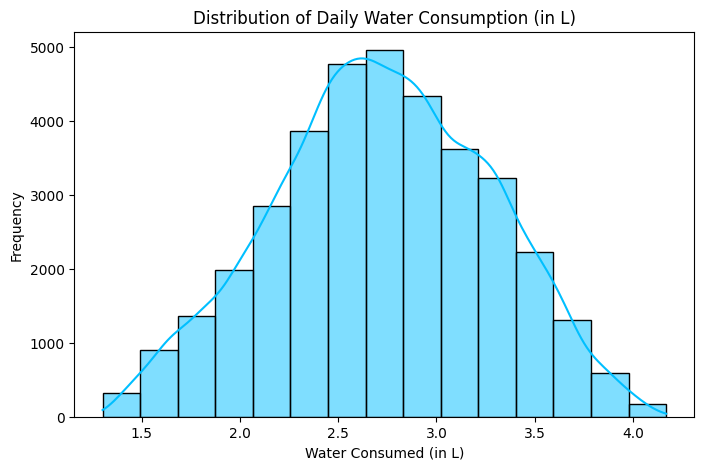

In [29]:
plt.figure(figsize=(8,5))
sns.histplot(df['Water_Consumed_Liters'], bins=15, kde=True, color='#00BFFF')
plt.title('Distribution of Daily Water Consumption (in L)')
plt.xlabel('Water Consumed (in L)')
plt.ylabel('Frequency')
plt.show()

/var/folders/y2/8yp864p50kqfdc9p6cr66nch0000gn/T/ipykernel_71165/399979319.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Activity_Level', y='Water_Consumed_Liters', palette=water_palette)
/var/folders/y2/8yp864p50kqfdc9p6cr66nch0000gn/T/ipykernel_71165/399979319.py:2: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.barplot(data=df, x='Activity_Level', y='Water_Consumed_Liters', palette=water_palette)


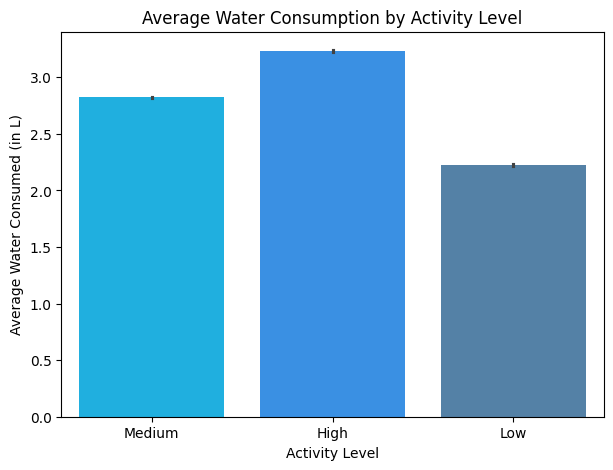

In [30]:
plt.figure(figsize=(7,5))
sns.barplot(data=df, x='Activity_Level', y='Water_Consumed_Liters', palette=water_palette)
plt.title('Average Water Consumption by Activity Level')
plt.xlabel('Activity Level')
plt.ylabel('Average Water Consumed (in L)')
plt.show()

/var/folders/y2/8yp864p50kqfdc9p6cr66nch0000gn/T/ipykernel_71165/1252672020.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='City', y='Water_Consumed_Liters', palette=water_palette)
/var/folders/y2/8yp864p50kqfdc9p6cr66nch0000gn/T/ipykernel_71165/1252672020.py:2: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df, x='City', y='Water_Consumed_Liters', palette=water_palette)


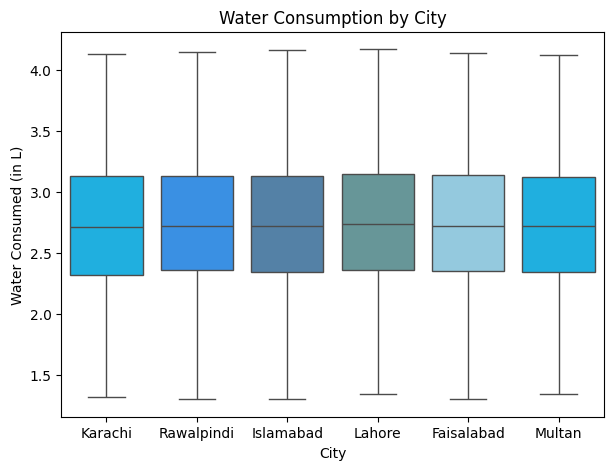

In [31]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='City', y='Water_Consumed_Liters', palette=water_palette)
plt.title('Water Consumption by City')
plt.xlabel('City')
plt.ylabel('Water Consumed (in L)')
plt.show()

/var/folders/y2/8yp864p50kqfdc9p6cr66nch0000gn/T/ipykernel_71165/1067145637.py:2: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(data=df, x='Temperature_C', y='Water_Consumed_Liters',


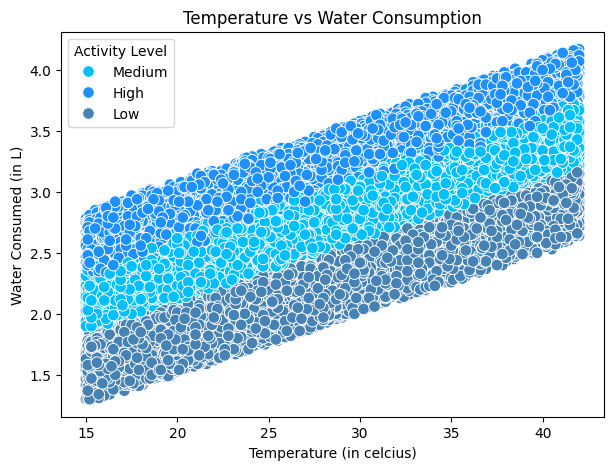

In [32]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='Temperature_C', y='Water_Consumed_Liters',
                hue='Activity_Level', palette=water_palette, s=70)
plt.title('Temperature vs Water Consumption')
plt.xlabel('Temperature (in celcius)')
plt.ylabel('Water Consumed (in L)')
plt.legend(title='Activity Level')
plt.show()

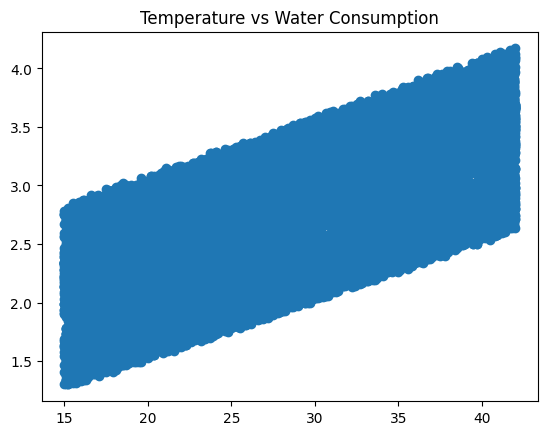

In [33]:
# check target noise 
plt.scatter(df['Temperature_C'], df['Water_Consumed_Liters'])
plt.title("Temperature vs Water Consumption")
plt.show()

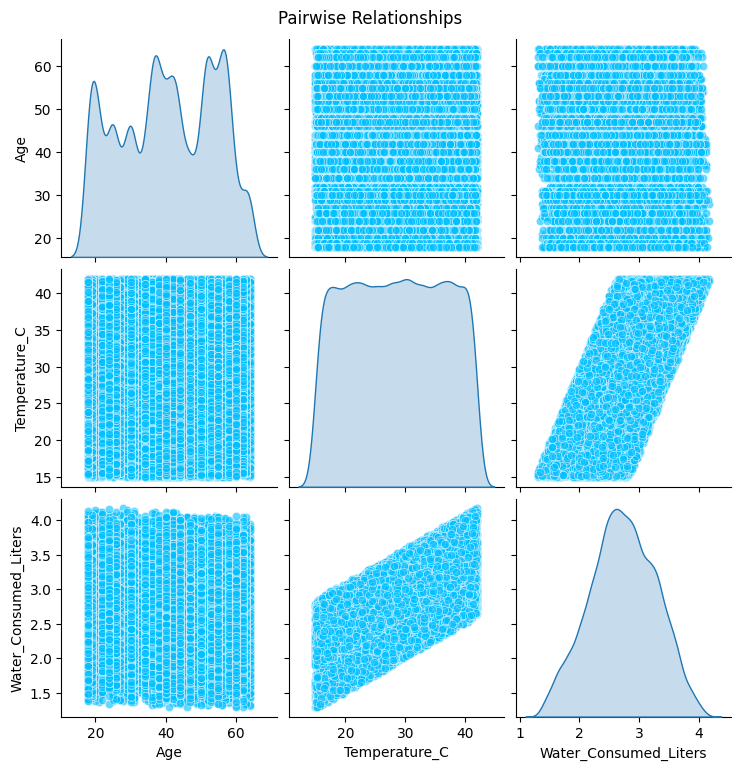

In [34]:
sns.pairplot(df[['Age', 'Temperature_C', 'Water_Consumed_Liters']], diag_kind='kde',
             plot_kws={'alpha':0.6, 'color':'#00BFFF'})
plt.suptitle('Pairwise Relationships', y=1.02)
plt.show()

# Data text summary

In [35]:
df.head()

,Date,Person_ID,Age,Gender,City,Temperature_C,Activity_Level,Water_Consumed_Liters
0,2025-01-01,P0001,21,Female,Karachi,22.1,Medium,2.40
1,2025-01-02,P0001,21,Female,Karachi,41.0,Medium,3.31
2,2025-01-03,P0001,21,Female,Karachi,26.4,High,2.96
3,2025-01-04,P0001,21,Female,Karachi,31.4,Medium,3.16
4,2025-01-05,P0001,21,Female,Karachi,35.7,Low,2.43


In [36]:
print("Summary Statistics:")
print(df.describe().T)

Summary Statistics:
                         count       mean        std   min    25%    50%  \
Age                    36500.0  40.430000  13.365253  18.0  29.75  40.50   
Temperature_C          36500.0  28.538447   7.789702  15.0  21.80  28.60   
Water_Consumed_Liters  36500.0   2.724002   0.550482   1.3   2.35   2.72   

                         75%    max  
Age                    52.00  64.00  
Temperature_C          35.30  42.00  
Water_Consumed_Liters   3.13   4.17  


# Preprocessing

In [37]:

predictors = ['Age', 'Temperature_C', 'Gender', 'City', 'Activity_Level']
# tried to add DayOfWeek, IsWeekend, etc but no luck in improving the score
added_data = []
predictors = predictors + added_data
target = ['Water_Consumed_Liters']
one_hot_encoded_features = ['Gender', 'City', 'Activity_Level']
not_needed_features = ['Date', 'Person_ID']

df_model = df.copy()

df_model = pd.get_dummies(df_model, columns=one_hot_encoded_features, drop_first=True)

X = df_model.drop(columns=not_needed_features + target)
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model
I chose a gradient boosted regressor. I made this decision because it combines all the weak learners and builds them sequentially. This allows it to learn from mistakes and capture subtle patterns that a single/many trees might miss. It can be easily tuned and gives more control to learn from the data. Furthermore, it outperforms random forests on tabular data (https://arxiv.org/abs/2204.12868). 

Therefore, now it was between different variations. To be fair, most variations (XGBoost, HistGradientBoostingRegressor) and they gave the same result. Possibly due to the data ceiling.

HistGradientBoostingRegressor more in depth here: https://www.youtube.com/watch?v=QwwM56rSkMM

In [38]:


hgb = HistGradientBoostingRegressor(
    learning_rate=0.03,
    max_iter=1500,
    max_depth=5,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=50,
    l2_regularization=0.0,
    random_state=42
)
hgb.fit(X_train, y_train)

y_pred = hgb.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("HistGradientBoostingRegressor Results")
print("R^2 Score:", round(r2, 4))
print("RMSE:", round(rmse, 4))

/Users/jonathancoletti/Documents/active_projects/WaterConsumptionPrediction/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor Results
R^2 Score: 0.9304
RMSE: 0.1464


Top Feature Importances:
                  Feature    Importance
9      Activity_Level_Low  1.055472e+00
1           Temperature_C  9.864365e-01
10  Activity_Level_Medium  1.743117e-01
0                     Age  4.986907e-03
5            City_Karachi  1.716729e-05
2             Gender_Male  1.238862e-05
7             City_Multan  2.834349e-06
3            Gender_Other  7.964515e-07
6             City_Lahore -1.322247e-05
8         City_Rawalpindi -1.696143e-05
4          City_Islamabad -4.302038e-05


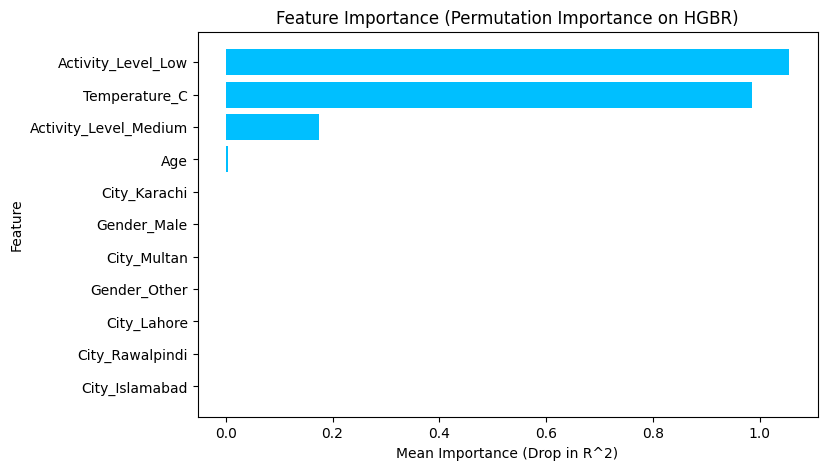

In [39]:
# permutation importances
perm_importance = permutation_importance(
    hgb, X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring='r2'
)

feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print("Top Feature Importances:")
print(importance_df)

plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#00BFFF')
plt.gca().invert_yaxis()
plt.title('Feature Importance (Permutation Importance on HGBR)')
plt.xlabel('Mean Importance (Drop in R^2)')
plt.ylabel('Feature')
plt.show()

# Future considerations
- Maybe try more or different feature engineering
- Try using PolynomialFeatures
- Log transform the target
- I tried stacking/blending but with the current features did not make a difference
- I tried tuning with `GridSearchCV` but it was still a very similar result
